In [1]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import numpy as np
import os

base_url = 'datasets/thai'
train_X = np.load(f'{base_url}/train_X.npy')
validation_X = np.load(f'{base_url}/validation_X.npy')
train_Y = np.load(f'{base_url}/train_y.npy')
validation_Y = np.load(f'{base_url}/validation_y.npy')

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
# first try: An embedding layer and a single bi-directional LSTM layer
from keras.models import Sequential
from keras.layers import Flatten, Bidirectional

def get_model():
    inputs = Input((128,))
    outputs = Embedding(261, 32)(inputs)
    outputs = Bidirectional(LSTM(64, return_sequences=True))(outputs)
    outputs = Dense(1, activation='sigmoid')(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [16]:
model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 128, 32)           8352      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          49664     
_________________________________________________________________
dense_2 (Dense)              (None, 128, 1)            129       
Total params: 58,145
Trainable params: 58,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Dense layer expects 3 dimensional output, so reshape y from (None, 128) to (None, 128, 1)
m_train = train_Y.shape[0]
m_val = validation_Y.shape[0]
train_Y = np.reshape(train_Y, (m_train, 128, 1))
validation_Y = np.reshape(validation_Y, (m_val, 128, 1))

In [34]:
history = model.fit(train_X, train_Y,
          batch_size = 512,
          epochs = 10,
          validation_data=(validation_X, validation_Y))

Train on 1101039 samples, validate on 15000 samples
Epoch 1/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.0328 - acc: 0.9888 - val_loss: 0.0340 - val_acc: 0.9884
Epoch 2/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.0326 - acc: 0.9889 - val_loss: 0.0338 - val_acc: 0.9884
Epoch 3/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.0324 - acc: 0.9890 - val_loss: 0.0339 - val_acc: 0.9884
Epoch 4/10
1101039/1101039 [==============================] - 1310s 1ms/step - loss: 0.0323 - acc: 0.9890 - val_loss: 0.0335 - val_acc: 0.9885
Epoch 5/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.0321 - acc: 0.9891 - val_loss: 0.0337 - val_acc: 0.9885
Epoch 6/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.0320 - acc: 0.9891 - val_loss: 0.0332 - val_acc: 0.9887
Epoch 7/10
1101039/1101039 [==============================] - 1311s 1ms/step - loss: 0.031

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline



def plot_loss_and_acc(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(18, 16), dpi=60)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.figure(figsize=(16, 16), dpi=60)
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()

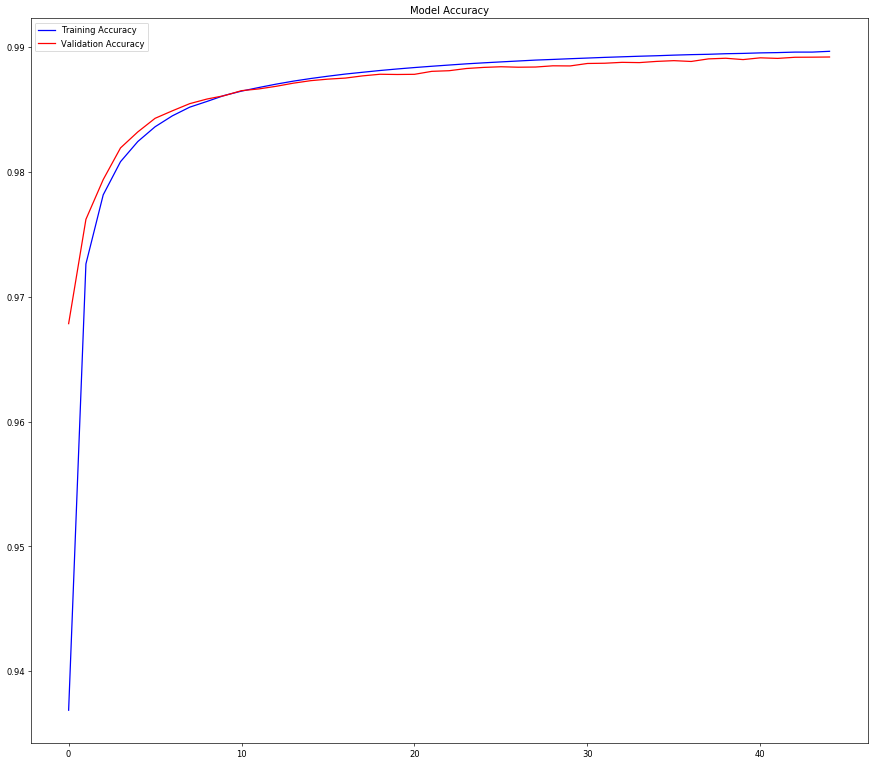

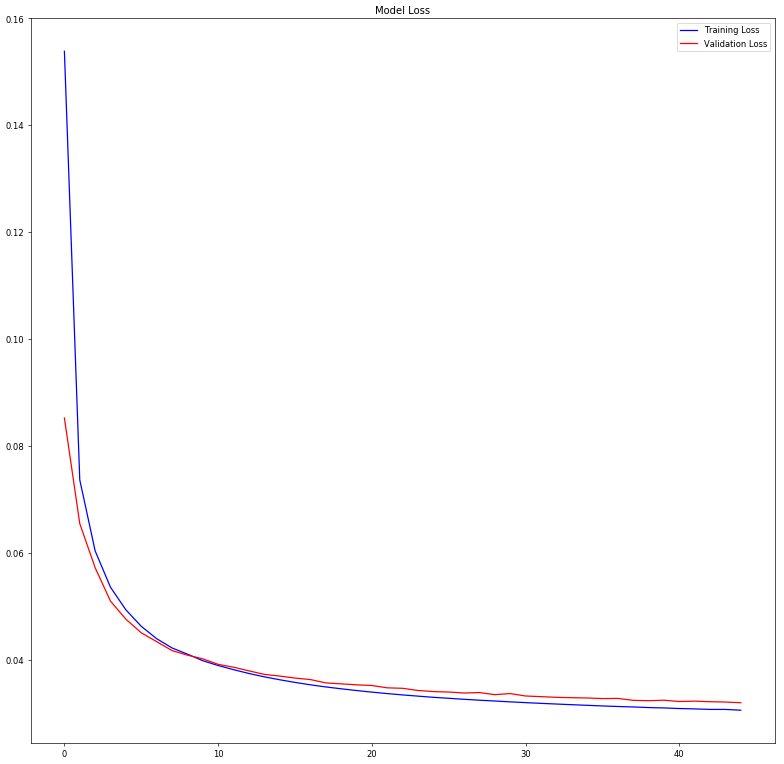

In [104]:
plot_loss_and_acc(history.history)

After 45 epochs, the training and validation accuracy remain close and are approaching 99%.  So, let's see how the model performs on the test set

In [105]:
test_X = np.load(f'{base_url}/test_X.npy')
test_Y = np.load(f'{base_url}/test_y.npy')
test_Y = np.reshape(test_Y, (15000, 128, 1))
test_metrics = model.evaluate(test_X, test_Y)
print('Loss:', test_metrics[0])
print('Acc:', test_metrics[1])

15000/15000 [==============================] - 64s 4ms/step
Loss: 0.03315871765762567
Acc: 0.9885682291984558


Test set accuracy of 98.86%. Not bad for a first attempt and, although the increments were small, the model does appear to have a little room to improve with more training, possibly passing 99% accuracy.

## Things that could be improved

- **Number of characters**: The character set doesn't only contain thai letters/numbers.  It also contains punctuation, all english letters, and also some other language characters.  I didn't want to make assumptions before training, but thinking about it again, I think it would make sense to convert all non-thai letters to a single symbol (maybe 'f' for foreign).  This would cut the feature space by at least 51 characters

- **Test a simpler model first**: The point of doing this project in the first place was to practice building a RNN.  As a result, the first model I tried uses an Embedding layer and LSTM.  However, considering that the input and output are both vectors with length 128, It might be possible to get good results with just densly connected layers or 1-dimensional CNNs